In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
! pip install tflite-model-maker

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 577 kB 25.3 MB/s 
     |████████████████████████████████| 1.3 MB 57.2 MB/s 
     |████████████████████████████████| 3.4 MB 53.9 MB/s 
     |████████████████████████████████| 60.2 MB 1.2 MB/s 
     |████████████████████████████████| 238 kB 66.6 MB/s 
     |████████████████████████████████| 77 kB 7.8 MB/s 
     |████████████████████████████████| 1.1 MB 49.5 MB/s 
     |████████████████████████████████| 10.9 MB 63.0 MB/s 
     |████████████████████████████████| 128 kB 79.3 MB/s 
     |████████████████████████████████| 840 kB 63.5 MB/s 
     |████████████████████████████████| 87 kB 7.0 MB/s 
     |████████████████████████████████| 25.3 MB 22.5 MB/s 
     |████████████████████████████████| 99 kB 12.1 MB/s 
     |████████████████████████████████| 352 kB 55.6 MB/s 
     |████████████████████████████████| 40 kB 7.8 MB/s 
     |██████████████████████████████

In [ ]:
import tensorflow as tf
import tflite_model_maker as mm
from tflite_model_maker import audio_classifier
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import glob
import random

from IPython.display import Audio, Image
from scipy.io import wavfile

print(f"TensorFlow Version: {tf.__version__}")
print(f"Model Maker Version: {mm.__version__}")

TensorFlow Version: 2.8.2
Model Maker Version: 0.4.2


In [ ]:
data_dir = '/content/drive/MyDrive/GTZAN_Dataset/Data/genres_split'

test_files = os.path.abspath(os.path.join(data_dir, 'test/*/*.wav'))

def get_random_audio_file():
  test_list = glob.glob(test_files)
  random_audio_path = random.choice(test_list)
  return random_audio_path




In [ ]:
# !pip install split-folders

In [ ]:
# import splitfolders
# splitfolders.ratio('/content/drive/MyDrive/GTZAN_Dataset/Data/genres_original', output="/content/drive/MyDrive/GTZAN_Dataset/Data/genres_split", seed=1337, ratio=(0.8,0.2)) 

In [ ]:
spec = audio_classifier.YamNetSpec(
    keep_yamnet_and_custom_heads=True,
    frame_step=3 * audio_classifier.YamNetSpec.EXPECTED_WAVEFORM_LENGTH,
    frame_length=6 * audio_classifier.YamNetSpec.EXPECTED_WAVEFORM_LENGTH)

In [ ]:
train_data = audio_classifier.DataLoader.from_folder(
    spec, os.path.join(data_dir, 'train'), cache=True)
train_data, validation_data = train_data.split(0.8)
test_data = audio_classifier.DataLoader.from_folder(
    spec, os.path.join(data_dir, 'test'), cache=True)

In [ ]:
batch_size = 32
epochs = 50

print('Training the model')
model = audio_classifier.create(
    train_data,
    spec,
    validation_data,
    batch_size=batch_size,
    epochs=epochs)

Training the model
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 classification_head (Dense)  (None, 10)               10250     
                                                                 
Total params: 10,250
Trainable params: 10,250
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
180/180 [==============================] - 773s 4s/step - loss: 1.4610 - acc: 0.5721 - val_loss: 0.9902 - val_acc: 0.7326
Epoch 2/50
180/180 [==============================] - 1s 7ms/step - loss: 0.8828 - acc: 0.7430 - val_loss: 0.7963 - val_acc: 0.7569
Epoch 3/50
180/180 [==============================] - 1s 6ms/step - loss: 0.7554 - acc: 0.7635 - val_loss: 0.7285 - val_acc: 0.7674
Epoch 4/50
180/180 [==============================] - 1s 7ms/step - loss: 0.7021 - acc: 0.7760 - val_loss: 0.7003 - val_acc: 0.7667
Epoch 5/50
180/180 [==========

In [ ]:
print('Evaluating the model')
model.evaluate(test_data)

Evaluating the model
57/57 [==============================] - 198s 3s/step - loss: 0.5138 - acc: 0.8367


[0.5137699246406555, 0.8366666436195374]

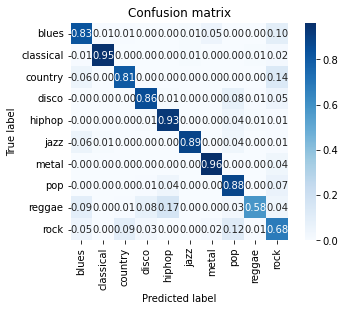

In [ ]:
def show_confusion_matrix(confusion, test_labels):
  """Compute confusion matrix and normalize."""
  confusion_normalized = confusion.astype("float") / confusion.sum(axis=1)
  axis_labels = test_labels
  ax = sns.heatmap(
      confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
      cmap='Blues', annot=True, fmt='.2f', square=True)
  plt.title("Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

confusion_matrix = model.confusion_matrix(test_data)
show_confusion_matrix(confusion_matrix.numpy(), test_data.index_to_label)

In [ ]:
serving_model = model.create_serving_model()

print(f'Model\'s input shape and type: {serving_model.inputs}')
print(f'Model\'s output shape and type: {serving_model.outputs}')

Model's input shape and type: [<KerasTensor: shape=(None, 15600) dtype=float32 (created by layer 'audio')>]
Model's output shape and type: [<KerasTensor: shape=(None, 521) dtype=float32 (created by layer 'keras_layer')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'sequential')>]


In [ ]:
random_audio="/content/drive/MyDrive/GTZAN_Dataset/Data/genres_original/blues/blues.00000.wav"
sample_rate, audio_data = wavfile.read(random_audio, 'rb')

audio_data = np.array(audio_data) / tf.int16.max
input_size = serving_model.input_shape[1]

splitted_audio_data = tf.signal.frame(audio_data, input_size, input_size, pad_end=True, pad_value=0)

print(f'Test audio path: {random_audio}')
print(f'Original size of the audio data: {len(audio_data)}')
print(f'Number of windows for inference: {len(splitted_audio_data)}')

Test audio path: /content/drive/MyDrive/GTZAN_Dataset/Data/genres_original/blues/blues.00000.wav
Original size of the audio data: 661794
Number of windows for inference: 43


In [ ]:
print(random_audio)

results = []
print('Result of the window ith:  your model class -> score,  (spec class -> score)')
for i, data in enumerate(splitted_audio_data):
  yamnet_output, inference = serving_model(data)
  results.append(inference[0].numpy())
  result_index = tf.argmax(inference[0])
  spec_result_index = tf.argmax(yamnet_output[0])
  t = spec._yamnet_labels()[spec_result_index]
  result_str = f'Result of the window {i}: ' \
  f'\t{test_data.index_to_label[result_index]} -> {inference[0][result_index].numpy():.3f}, ' \
  f'\t({spec._yamnet_labels()[spec_result_index]} -> {yamnet_output[0][spec_result_index]:.3f})'
  print(result_str)


results_np = np.array(results)
mean_results = results_np.mean(axis=0)
result_index = mean_results.argmax()
print(f'Mean result: {test_data.index_to_label[result_index]} -> {mean_results[result_index]}')

/content/drive/MyDrive/GTZAN_Dataset/Data/genres_original/blues/blues.00000.wav
Result of the window ith:  your model class -> score,  (spec class -> score)
Result of the window 0: 	blues -> 0.904, 	(Music -> 0.582)
Result of the window 1: 	jazz -> 0.922, 	(Music -> 0.559)
Result of the window 2: 	country -> 0.854, 	(Music -> 0.967)
Result of the window 3: 	blues -> 0.987, 	(Music -> 0.700)
Result of the window 4: 	country -> 0.902, 	(Music -> 0.657)
Result of the window 5: 	blues -> 0.955, 	(Music -> 0.924)
Result of the window 6: 	blues -> 0.877, 	(Music -> 0.796)
Result of the window 7: 	blues -> 0.558, 	(Music -> 0.762)
Result of the window 8: 	blues -> 0.829, 	(Music -> 0.960)
Result of the window 9: 	jazz -> 0.561, 	(Music -> 0.987)
Result of the window 10: 	blues -> 0.971, 	(Music -> 0.748)
Result of the window 11: 	blues -> 0.911, 	(Music -> 0.938)
Result of the window 12: 	rock -> 0.526, 	(Music -> 0.794)
Result of the window 13: 	blues -> 0.995, 	(Music -> 0.952)
Result of th